In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

## Define neural net class

In [13]:
class FeedFwdNN(nn.Module):
    def __init__(self, input_size, output_size, optim_lr=0.0001):
        # torch inheritance thing
        super(FeedFwdNN, self).__init__()

        # the network 
        self.dense1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(64, 64)
        self.relu3 = nn.ReLU()
        self.dense4 = nn.Linear(64, 64)
        self.relu4 = nn.ReLU()
        self.out_dense = nn.Linear(64, output_size)
        
        # optimizer and loss
        self.optimizer = optim.Adam(self.parameters(), lr=optim_lr)
        self.criteria = nn.MSELoss()
        self.loss = None
    
    def forward(self, input_data):
        """
        Description:
        Forward pass of the neural network.

        Inputs:
        input_data: tensor of a single sample of data

        Ouput:
        returns tensor of network's final output
        """
        x = self.dense1(input_data)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = self.relu3(x)
        x = self.dense4(x)
        x = self.relu4(x)
        x = self.out_dense(x)
        return x
    
    def backward(self, outputs, targets):
        """
        Description:
        Backward pass of the neural network. Loss computed, optimizer
        zeroed, loss and optimizer complete backward step.

        Inputs:
        outputs: tensor of network's predicted outputs of a given sample
                 (i.e. output of forward pass)
        targets: actual output tensor for given sample

        Output:
        returns loss value between outputs and targets
        """
        self.loss = self.criteria(outputs, targets)
        loss_copy = self.loss
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        return loss_copy
    
    def compute_loss(self, outputs, targets):
        """
        Description:
        Computes loss without actually backpropagating. Used for checking
        network's progress with test data.

        Inputs:
        outputs: tensor of network's predicted outputs of a given sample
                 (i.e. output of forward pass)
        targets: actual output tensor for given sample

        Output:
        returns loss value between outputs and targets
        """
        return self.criteria(outputs, targets)

## Define a few functions for generating data

In [14]:
def underdamped_position(t_values, amplitude, gamma, Omega, phi):
    """
    Description:
    Calculates the position value of an underdamped harmonic oscillator
    with the inputted t_values and parameters.
    For math, see: https://phys.libretexts.org/Bookshelves/Mathematical_Physics_and_Pedagogy/Complex_Methods_for_the_Sciences_(Chong)/05%3A_Complex_Oscillations/5.03%3A_General_Solution_for_the_Damped_Harmonic_Oscillator

    Inputs:
    t_values: np array or scalar of time values, output has same shape
    amplitude: factor multiplied by entire expression
    gamma: damping coefficient
    Omega: sqrt((angular frequency)**2 - gamma**2). Note that this is 
           capital Omega, not to be confused with lowercase omega 
           (angular frequency). Also note that omega > gamma for 
           underdamped case.
    phi: phase shift

    Output:
    returns np array or scalar of position values, calculated using 
    general solution to underdamped harmonic oscillator (see url in 
    description).

    """
    return amplitude * np.exp(-gamma * t_values) * np.cos(Omega * t_values + phi)

In [15]:
def generate_params(oscillation_type="good"):
    """
    Description:
    Generates random values of Omega, gamma, amplitude, and phi that fit
    constraints imposed by oscillation_type.

    Inputs:
    oscillation_type: either "good" (small gamma) or "quick-damp" (larger
                      gamma)

    Output:
    returns amplitude, gamma, Omega, phi

    """
    if (oscillation_type == "good"):
        # ensure that omega_0 and gamma are 1 order of magnitude different
        # NOTE omega_0 somewhat arbitrarily constrained to range
        omega_0 = (1 - 0.6) * np.random.random() + 0.6
        gamma = (0.1 - 0.01) * np.random.random() + 0.01
    elif (oscillation_type == "quick-damp"):
        # omega_0 and gamma will be within (closeness * 10)% of each other
        closeness = 0.9
        upper_limit = np.random.random()
        lower_limit = upper_limit - closeness * upper_limit  
        omega_0 = (upper_limit - lower_limit) * np.random.random() + lower_limit
        gamma = (upper_limit - lower_limit) * np.random.random() + lower_limit
        
        # underdamped constraint is omega_0 > gamma
        while (gamma > omega_0):
            gamma = (upper_limit - lower_limit) * np.random.random() + lower_limit

    amplitude = np.random.random()  # range of 0-1
    phi = np.random.random()  # range of 0-1
    Omega = np.sqrt(omega_0**2 - gamma**2)

    return amplitude, gamma, Omega, phi

In [16]:
def generate_independent_data(file_path, file_mode, num_samples, t_start=0, t_stop=100, t_step=1, oscillation_type="good"):
    """
    Description:
    Generates a random value of t and random param values, then computes
    the underdamped harmonic oscillator position. Does this num_samples
    times and then writes data to csv.

    Inputs:
    file_path: name of csv to write generated data to
    file_mode: mode to open file_path in
    num_samples: number of random samples to generate (output file will
                 have this many lines +1 for header)
    t_start: beginning value of t range
    t_stop: ending value of t range
    oscillation_type: either "good" (small gamma) or "quick-damp" (larger
                      gamma)

    Output:
    returns None, writes data to file
    """
    generated_samples = []
    t_choices = np.arange(t_start, t_stop + t_step, t_step)

    for i in range(num_samples):
        t = np.random.choice(t_choices)
        amplitude, gamma, Omega, phi = generate_params(oscillation_type)
        position = underdamped_position(t, amplitude, gamma, Omega, phi)
        generated_samples.append([t, Omega, gamma, phi, amplitude, position])

    with open(file_path, file_mode) as fi:
        if (file_mode == "w"):
            fi.write("t,Omega,gamma,phi,amplitude,y\n")

        for sample in generated_samples:
            fi.write(f"{','.join([str(val) for val in sample])}\n")

In [17]:
def generate_range_data(file_path, file_mode, t_start=0, t_stop=100, t_step=1, oscillation_type="good"):
    """
    Description: generates a set of underdamped harmonic oscillator data
                 using a fixed range of t and random constants.

    Inputs:
    file_path: where to write data to 
    file_mode: mode to open data file in
    t_start: starting value of t (defaults to 0)
    t_stop: stopping value of t (defaults to 100)
    t_step: number of values from t_start to t_stop (defaults to 1000)
    oscillation_type: "good" or "quick-damp"

    Output:
    returns None, writes data to file_path
    """
    # hold range of t values constant across all generated data
    # this creates 1000 samples
    t_values = np.arange(t_start, t_stop + t_step, t_step)

    # randomly generate parameters
    amplitude, gamma, Omega, phi = generate_params(oscillation_type)

    # analytical solution (y values)
    positions = underdamped_position(t_values, amplitude, gamma, Omega, phi)

    # write params and y vs. t to csv
    with open(file_path, file_mode) as fi:
        if file_mode == "w":
            fi.write("t,Omega,gamma,phi,amplitude,y\n")

        for i in range(len(t_values)):
            fi.write(f"{t_values[i]},{Omega},{gamma},{phi},{amplitude},{positions[i]}\n")

## Create train dataset

In [25]:
%%time
data_dir = "data"
os.system(f"mkdir -p {data_dir}")

train_samples = int(1e6)
train_dataset_name = "underdamped_independent_train"
t_start = 0
t_stop = 50
t_step = 0.1
oscillation_type = "good"

train_file_path = f"{data_dir}/{train_dataset_name}_{oscillation_type}_samples={train_samples}_t0={t_start}_tf={t_stop}_ts={t_step}.csv"
file_mode = "w"
generate_independent_data(train_file_path, file_mode, train_samples, t_start=t_start, t_stop=t_stop, t_step=t_step, oscillation_type=oscillation_type)

CPU times: user 19.8 s, sys: 575 ms, total: 20.4 s
Wall time: 19.9 s


## Create test dataset

In [26]:
%%time
test_samples = int(1e4)
test_dataset_name = "underdamped_independent_test"

test_file_path = f"{data_dir}/{test_dataset_name}_{oscillation_type}_samples={test_samples}_t0={t_start}_tf={t_stop}_ts={t_step}.csv"
file_mode = "w"
generate_independent_data(test_file_path, file_mode, test_samples, t_start=t_start, t_stop=t_stop, t_step=t_step, oscillation_type=oscillation_type)

CPU times: user 232 ms, sys: 29 ms, total: 261 ms
Wall time: 227 ms


## Load and prepare train/test datasets

In [27]:
# train
train_df = pd.read_csv(train_file_path)
feat_cols = [col for col in train_df.columns if col != "y"]
X_train = torch.tensor(train_df[feat_cols].values).float()
y_train = torch.tensor(train_df["y"].values).float()
y_train = y_train.reshape(y_train.shape[0], 1)

# test
test_df = pd.read_csv(test_file_path)
X_test = torch.tensor(test_df[feat_cols].values).float()
y_test = torch.tensor(test_df["y"].values).float()
y_test = y_test.reshape(y_test.shape[0], 1)

## Initialize nn

In [37]:
input_len = X_train.shape[1]
num_outputs = 1  # nn predicts a scalar
model = FeedFwdNN(input_len, num_outputs)
model_dir = "models"
model_path = f"{model_dir}/{train_file_path.replace('data/', '').replace('train_', '').replace('.csv', '.pt')}"

## Training loop

In [50]:
# parameters of training loop
num_epochs = 30
batch_size = 64
batches = torch.arange(0, X_train.shape[0], batch_size)
train_losses = []  
test_losses = []

for epoch_idx in range(num_epochs):
    start = time.time()
    print(f"epoch: {epoch_idx}")

    for batch in batches:
        X_batch = X_train[batch:batch + batch_size]
        y_batch = y_train[batch:batch + batch_size]
        y_predictions = model.forward(X_batch)
        train_loss = model.backward(y_predictions, y_batch)

    y_test_predictions = model.forward(X_test)
    test_loss = model.compute_loss(y_test_predictions, y_test)
    train_losses.append(train_loss.detach().numpy())
    test_losses.append(test_loss.detach().numpy())
    print(f"train loss = {train_loss}, test loss = {test_loss}, time = {time.time() - start:.2f} seconds\n")

# save model
os.system(f"rm -rf {model_path}")  
torch.save(model.state_dict(), model_path)

epoch: 0
train loss = 0.0022897301241755486, test loss = 0.004156360402703285, time = 15.81 seconds

epoch: 1
train loss = 0.0018305107951164246, test loss = 0.003977814689278603, time = 15.40 seconds

epoch: 2
train loss = 0.0018501289887353778, test loss = 0.0043180277571082115, time = 15.32 seconds

epoch: 3
train loss = 0.0023389810230582952, test loss = 0.004590102005749941, time = 15.42 seconds

epoch: 4
train loss = 0.0017466350691393018, test loss = 0.0032440205104649067, time = 15.33 seconds

epoch: 5
train loss = 0.0013843757333233953, test loss = 0.002812659367918968, time = 15.28 seconds

epoch: 6
train loss = 0.0015884863678365946, test loss = 0.00231042318046093, time = 15.19 seconds

epoch: 7
train loss = 0.0016094848979264498, test loss = 0.00281280605122447, time = 15.22 seconds

epoch: 8
train loss = 0.0008199686417356133, test loss = 0.002031445037573576, time = 15.27 seconds

epoch: 9
train loss = 0.0004137715441174805, test loss = 0.001585288206115365, time = 15.22

In [84]:
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["font.size"] = 16

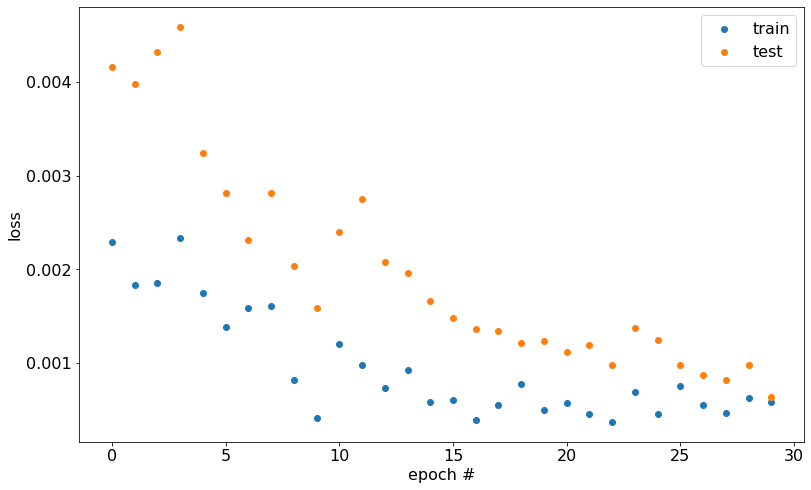

In [85]:
# plot losses
epoch_indexes = [i for i in range(num_epochs)]
plt.scatter(epoch_indexes, train_losses, label="train")
plt.scatter(epoch_indexes, test_losses, label="test")
plt.legend()
plt.xlabel("epoch #")
plt.ylabel("loss")
plt.show()

## Create data over an interval of t

In [68]:
dataset_type = "underdamped_range_validation"
validation_path = f"{data_dir}/{dataset_type}_{oscillation_type}_t0={t_start}_tf={t_stop}_ts={t_step}.csv"
generate_range_data(validation_path, file_mode, t_start=t_start, t_stop=t_stop, t_step=t_step, oscillation_type="good")
validation_df = pd.read_csv(validation_path)

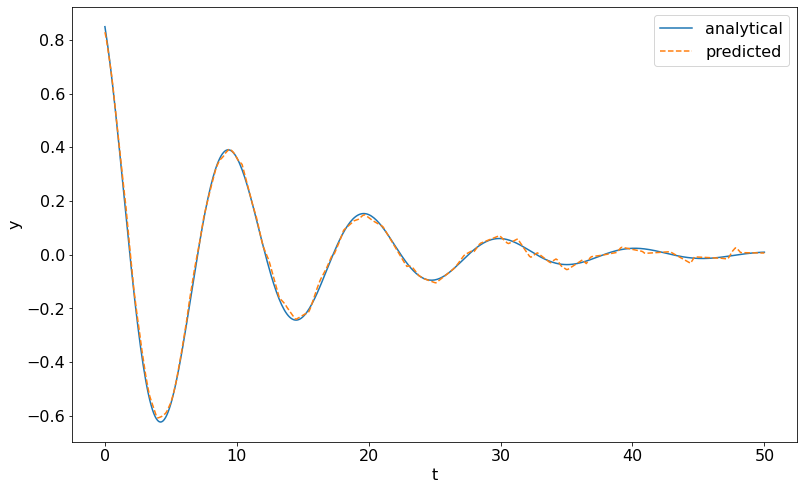

In [86]:
# make predictions over this new range of data
X_val = torch.tensor(validation_df[feat_cols].values).float()
y_val = validation_df["y"].to_numpy()
val_preds = model(X_val)
val_preds = val_preds.detach().numpy()
val_preds = val_preds.reshape(val_preds.shape[0])

plt.plot(validation_df["t"], y_val, label="analytical")
plt.plot(validation_df["t"], val_preds, "--", label="predicted")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.show()